# Example: Regression with `QNNRegressor` and Variance Regularization

In this example we show how to train the `QNNRegressor` to fit a logarithm. We will also use this demonstrator to show how Variance Regularization can reduce noise and improve fit quality.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from squlearn import Executor
from squlearn.feature_map import ChebRx
from squlearn.observable import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss, VarianceLoss
from squlearn.optimizers import SLSQP

We will use Qiskit's `StatevectorSimulator` for trainning.

In [2]:
executor = Executor("statevector_simulator")

## `QNNRegressor` Setup

We start by defining a parameterized quantum circuit (PQC)

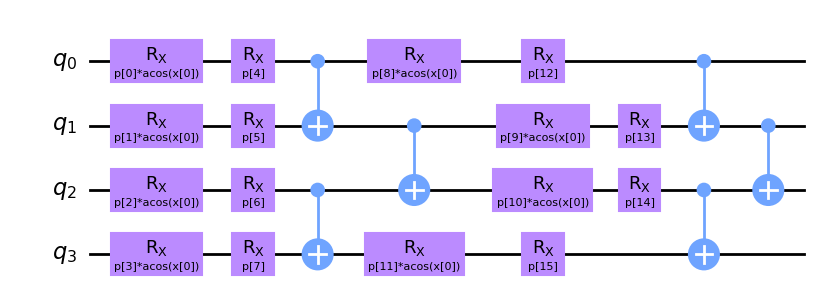

In [3]:
nqubits = 4
number_of_layers = 2

pqc = ChebRx(nqubits, 1, num_layers=number_of_layers)
pqc.draw("mpl")

We also need an observable

In [4]:
ising_op = IsingHamiltonian(nqubits, I="S", Z="S", ZZ="S")
print(ising_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[1]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[2]),
 ParameterExpression(1.0*p[2])])


Now we can create the `QNNRegressor` with the PQC and cost operator. We also specify `SquaredLoss` and `SLSQP` as the loss function and optimizer respectively. Finally we specify random initial parameters for both, the PQC and cost operator.

We will further specify a variance factor of $0.0005$, which will result in the models variance getting added to the loss function.

In [5]:
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
param_op_ini = np.random.rand(ising_op.num_parameters)

reg = QNNRegressor(
    pqc,
    ising_op,
    executor,
    SquaredLoss(),
    SLSQP(),
    param_ini,
    param_op_ini,
    variance=0.0005,
)

## Training

Now we are ready to train the model to fit the logarithm funciton

In [6]:
x_space = np.arange(0.1, 0.9, 0.1)
ref_values = np.log(x_space)

reg.fit(x_space, ref_values)

theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Current value: 15.066309647593316
theta [0.77770241 0.23754122 0.82427853 0.9657492  0.97260111 0.45344925
 0.60904246 0.77552651 0.64161334 0.72201823 0.03503652 0.29844947
 0.05851249 0.85706094 0.37285403 0.67984795 0.25627995 0.34758122
 0.00941277]
Grad length: 23.5336636954544
grad [ -0.05707629  -1.19647308  -2.50681693  -0.15744595  -0.26520563
  -0.92119058  -1.99943269  -0.1152211    3.47650978  -3.85932083
  -1.36927197  -0.15744595   2.57728409  -3.34082411  -0.90952077
  -0.1152211   19.64618798  -1.27442393 -10.2975062 ]
theta [  0.8347787    1.4340143    3.33109546   1.12319515   1.23780675
   1.37463983   2.60847516   0.89074761  -2.83489644   4.58133906
   1.40430849   0.45589542  -2.51877159   4.19788506   1.2823748
   0.79506905 -19.38990803   1.62200

## Evaluation

Let's check the trained parameters of the PQC and operator

In [7]:
print("Result PQC params:", reg._param)
print("Result operator params:", reg._param_op)

Result PQC params: [ 3.41062806  0.63125445  4.40119971  1.25919873 -2.35420942 -0.04354262
 -4.22612537 -0.19520602  0.21838745  0.78754811  3.05189136  0.59189901
 -0.52783347 -1.55477309 -2.08338942 -0.29088459]
Result operator params: [-1.57350653  0.87778247 -0.26884315]


Also let's plot the predicted function vs. the actual logarithm function

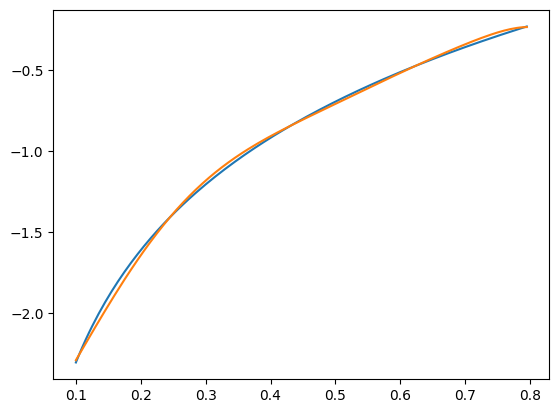

In [8]:
x = np.arange(np.min(x_space), np.max(x_space), 0.005)
y = reg.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

Let's also plot the error of the QNN.

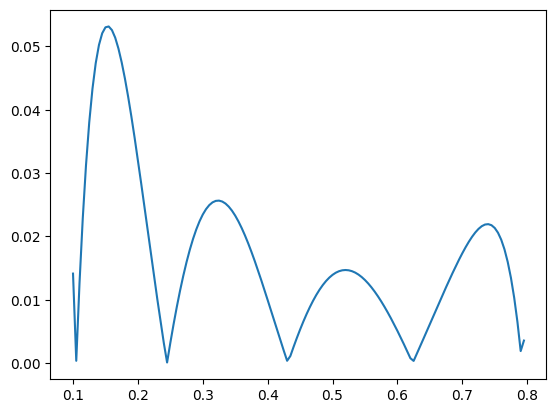

In [9]:
plt.plot(x, np.abs(y - np.log(x)))

## Evaluation on noisy simulator

Finally let's evaluate the trained `QNNRegressor` on Qiskit's `QasmSimulator`.

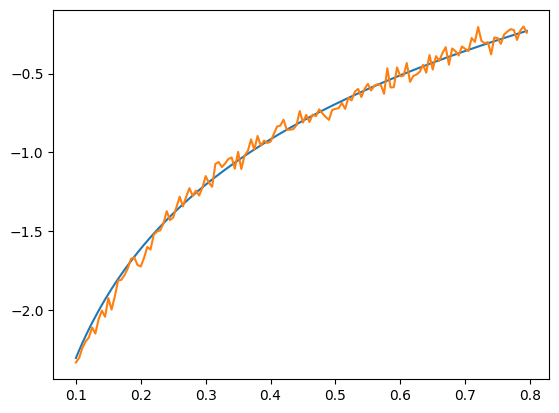

In [10]:
qasm = Executor("qasm_simulator")
qnn_qasm = QNNRegressor(
    pqc, ising_op, qasm, [SquaredLoss, VarianceLoss], SLSQP(), reg.param, reg.param_op
)
qnn_qasm._is_fitted = True
y = qnn_qasm.predict(x)
plt.plot(x, np.log(x))
plt.plot(x, y)

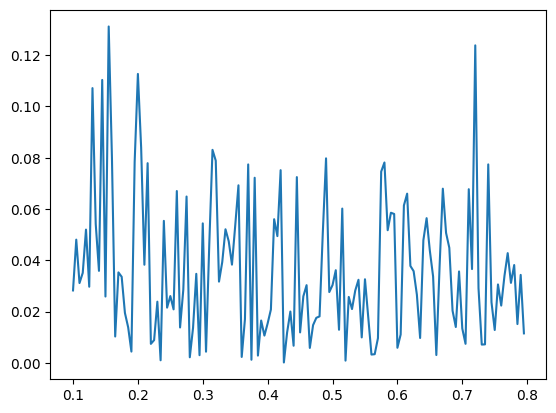

In [11]:
plt.plot(x, np.abs(y - np.log(x)))

We can see that the model is subject to less noise, than without variance regularization.